In [1]:
import importlib
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nue as nue
importlib.reload(nue)

<module 'nue' from '/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py'>

In [2]:
nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/rockbox/intrnue_rockbox.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuu_df_0 = pd.read_hdf(nue_file,key="mcnu")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")
nue_slctrk_df_0 = pd.read_hdf(nue_file,key="slctrk")
nue_slcshw_df_0 = pd.read_hdf(nue_file,key="slcshw")

nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

nue_hdr_df = nue.flatten_df(nue_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
nue_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_intrnue_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
nue_sub_df = nue_hdr_df.merge(nue_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [3]:
bnb_file = "/sbnd/data/users/lynnt/v09_75_03_02/rockbox/bnb_rockbox.df"
bnb_hdr_df_0 = pd.read_hdf(bnb_file,key="hdr")
bnb_nuu_df_0 = pd.read_hdf(bnb_file,key="mcnu")
bnb_nuprim_df_0 = pd.read_hdf(bnb_file,key="mcnuprim")
bnb_slctrk_df_0 = pd.read_hdf(bnb_file,key="slctrk")
bnb_slcshw_df_0 = pd.read_hdf(bnb_file,key="slcshw")

bnb_hdr_df = nue.flatten_df(bnb_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
bnb_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_bnb_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
bnb_sub_df = bnb_hdr_df.merge(bnb_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [4]:
print("bnb POT:", np.sum(bnb_sub_df.rec_hdr_pot))
print("nue POT:", np.sum(nue_sub_df.rec_hdr_pot))
nue.nue_scale = np.sum(bnb_sub_df.rec_hdr_pot) / np.sum(nue_sub_df.rec_hdr_pot)
print("scale nue events down by: ", nue.nue_scale)

bnb POT: 1.4196215e+18
nue POT: 8.083963e+19
scale nue events down by:  0.01756096


In [5]:
# make nue dataframes
nue_nuprim_df = nue_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(nue_nuprim_df)
whereSig = ((nue_nuprim_df.iscc==1) & (abs(nue_nuprim_df.pdg)==12) & (abs(nue_nuprim_df.prim.pdg)==11) & (nue_nuprim_df.prim.startE > 0.2))
nue_nuprim_df = nue.defineBackground(nue_nuprim_df)
nue_nuprim_df["signal"] = np.where(whereFV & whereSig,0,nue_nuprim_df["signal"])

nue_nu_df = nue_nuprim_df.loc[:,:,:,0]
nue_nu_df = nue.flatten_df(nue_nu_df)
nue_nu_df["nu_index"] = nue_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
nue_pdg_counts = nue.getPDGCounts(nue_nuprim_df)

# merge the pdg counts into the full nue_nu_df 
nue_nu_df = nue_nu_df.merge(nue_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# get slcpfp dataframe 
slcpfp_nue_df = nue.getPFP(nue_slcshw_df_0,nue_slctrk_df_0)

# merge slcpfp with neutrino events 
slcpfp_nue_nu_df = slcpfp_nue_df.merge(nue_nu_df,on=nu_idx_set,how="left")
slcpfp_nue_nu_df["signal"] = np.where(slcpfp_nue_df.slc_tmatch_idx==-999,5,slcpfp_nue_nu_df['signal'])

In [6]:
# make bnb dataframes
bnb_nuprim_df = bnb_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(bnb_nuprim_df)
bnb_nuprim_df = nue.defineBackground(bnb_nuprim_df)

bnb_nu_df = bnb_nuprim_df.loc[:,:,:,0]
bnb_nu_df = nue.flatten_df(bnb_nu_df)
bnb_nu_df["nu_index"] = bnb_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
bnb_pdg_counts = nue.getPDGCounts(bnb_nuprim_df)

# merge the pdg counts into the full bnb_nu_df 
bnb_nu_df = bnb_nu_df.merge(bnb_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# remove nue events from the bnb sample
bnb_rm_nue = nue.flatten_df(bnb_nuu_df_0[abs(bnb_nuu_df_0.pdg) == 12])[["entry"]]
bnb_nu_df = (bnb_nu_df.merge(bnb_rm_nue,how="left",on=["entry"], indicator=True)
     .query('_merge == "left_only"')
     .drop('_merge', 1))

# get slcpfp dataframe 
slcpfp_bnb_df = nue.getPFP(bnb_slcshw_df_0,bnb_slctrk_df_0)

# merge slcpfp with neutrino events 
slcpfp_bnb_nu_df = slcpfp_bnb_df.merge(bnb_nu_df,on=nu_idx_set,how="left")
slcpfp_bnb_nu_df["signal"] = np.where(slcpfp_bnb_df.slc_tmatch_idx==-999,5,slcpfp_bnb_nu_df['signal'])

In [7]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_intrnue_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
nue_opt0_df["frac_pe"] = (nue_opt0_df.hypo_pe - nue_opt0_df.flash_pe)/nue_opt0_df.flash_pe
nue_opt0_df = nue_opt0_df[nue_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
nue_opt0_df = nue_opt0_df[(nue_opt0_df.score == nue_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
nue_hdr_opt0_df = nue_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(nue_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_nue_nu_df = slcpfp_nue_nu_df.merge(nue_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [8]:
bnb_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_bnb_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
bnb_opt0_df["frac_pe"] = (bnb_opt0_df.hypo_pe - bnb_opt0_df.flash_pe)/bnb_opt0_df.flash_pe
bnb_opt0_df = bnb_opt0_df[bnb_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
bnb_opt0_df = bnb_opt0_df[(bnb_opt0_df.score == bnb_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
bnb_hdr_opt0_df = bnb_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(bnb_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_bnb_nu_df = slcpfp_bnb_nu_df.merge(bnb_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [25]:
# print number of slc/evt for nue selection
print("number of signal events:", len(nue.get_signal_evt(nue_nu_df)))
print("number of signal slices (evt) after reconstruction: ", 
      len(nue.get_signal_slc(slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(slcpfp_nue_nu_df)),")")

# pre-selection
## reco vertex in FV 
## not a clear cosmic 
## at least one pfp in a slice with track score < 0.6

pre_slcpfp_nue_nu_df = nue.cutPreselection(slcpfp_nue_nu_df,whereShower=False)
pre_slcpfp_nue_nu_df["shower"] = np.where(pre_slcpfp_nue_nu_df.pfp_trackScore<0.5, True, False)

number of signal events: 2488
number of signal slices (evt) after reconstruction:  2717 ( 2456 )


In [55]:
print("efficiency (evt)", (2005)/2488)
print("purity (slices)" , (2010*nue.nue_scale)/(1228+2010*nue.nue_scale))

efficiency (evt) 0.8058681672025724
purity (slices) 0.027940790027200946


In [26]:
pre_slcshw_nue_nu_df = pre_slcpfp_nue_nu_df[pre_slcpfp_nue_nu_df.shower==True]
pre_slcshw_nue_nu_df = pre_slcshw_nue_nu_df[pre_slcshw_nue_nu_df.shw_energy == pre_slcshw_nue_nu_df.groupby(slc_idx_set).shw_energy.transform(max)]
pre_slcshw_nue_nu_df = pre_slcshw_nue_nu_df[pre_slcshw_nue_nu_df.shw_energy > 0.2]
print("number of signal slices (evt) after pre-selection: ", 
      len(nue.get_signal_slc(pre_slcshw_nue_nu_df)),
      "(",len(nue.get_signal_evt(pre_slcshw_nue_nu_df)),")")

# containment
con_slcshw_nue_nu_df = nue.cutContainment(pre_slcshw_nue_nu_df,whereTrkCont=False)
print("number of signal slices (evt) after containment: ", 
      len(nue.get_signal_slc(con_slcshw_nue_nu_df)),
      "(",len(nue.get_signal_evt(con_slcshw_nue_nu_df)),")")

# cosmic rejection
lcr_slcshw_nue_nu_df = nue.cutCRUMBS(con_slcshw_nue_nu_df,cut_val=0.08)
print("number of signal slices (evt) after CRUMBS cut: ",
      len(nue.get_signal_slc(lcr_slcshw_nue_nu_df)),
      "(",len(nue.get_signal_evt(lcr_slcshw_nue_nu_df)),")")
lcr_slcshw_nue_nu_df = lcr_slcshw_nue_nu_df.drop(columns=["rec.slc.reco.pfp__index"])

number of signal slices (evt) after pre-selection:  2227 ( 2220 )
number of signal slices (evt) after containment:  2010 ( 2005 )
number of signal slices (evt) after CRUMBS cut:  1746 ( 1746 )


In [43]:
# pre-selection
## reco vertex in FV 
## not a clear cosmic 
## at least one pfp in a slice with track score < 0.6

pre_slcpfp_bnb_nu_df = nue.cutPreselection(slcpfp_bnb_nu_df,whereShower=False)
pre_slcpfp_bnb_nu_df["shower"] = np.where(pre_slcpfp_bnb_nu_df.pfp_trackScore<0.5, True, False)

In [47]:
print("number of bacgkr slices (evt) after reconstruction: ", 
      len(nue.get_backgr_slc(slcpfp_bnb_nu_df)),
      "(",len(nue.get_backgr_evt(slcpfp_bnb_nu_df)),")")

number of bacgkr slices (evt) after reconstruction:  163664 ( 33362 )


In [29]:
pre_slcshw_bnb_nu_df = pre_slcpfp_bnb_nu_df[pre_slcpfp_bnb_nu_df.shower==True]
pre_slcshw_bnb_nu_df = pre_slcshw_bnb_nu_df[pre_slcshw_bnb_nu_df.shw_energy == pre_slcshw_bnb_nu_df.groupby(slc_idx_set).shw_energy.transform(max)]
pre_slcshw_bnb_nu_df = pre_slcshw_bnb_nu_df[pre_slcshw_bnb_nu_df.shw_energy > 0.2]
print("number of backgr slices (evt) after pre-selection: ", 
      len(nue.get_backgr_slc(pre_slcshw_bnb_nu_df)))
# containment
con_slcshw_bnb_nu_df = nue.cutContainment(pre_slcshw_bnb_nu_df,whereTrkCont=False)
print("number of backgr slices (evt) after containment: ", 
      len(nue.get_backgr_slc(con_slcshw_bnb_nu_df)))
# cosmic rejection
lcr_slcshw_bnb_nu_df = nue.cutCRUMBS(con_slcshw_bnb_nu_df,cut_val=0.08)
print("number of backgr slices (evt) after CRUMBS cut: ",
      len(nue.get_backgr_slc(lcr_slcshw_bnb_nu_df)))

lcr_slcshw_bnb_nu_df = lcr_slcshw_bnb_nu_df.drop(columns=["rec.slc.reco.pfp__index"])

number of backgr slices (evt) after pre-selection:  1308
number of backgr slices (evt) after containment:  1228
number of backgr slices (evt) after CRUMBS cut:  680


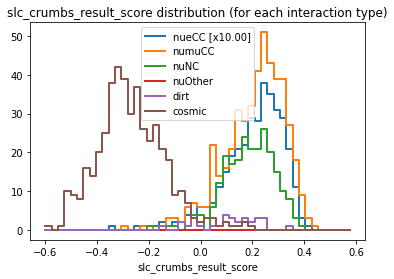

In [30]:
nue.plot_var(df=nue.get_slc(con_slcshw_bnb_nu_df),
             df_add=nue.get_slc(con_slcshw_nue_nu_df),
             var="slc_crumbs_result_score",
             bins=np.linspace(-0.6,0.6,50),
             mult_factor=10)

In [31]:
eff_den = len(nue.get_signal_evt(nue_nu_df)) # total number of signal events

print("loose cosmic rejection")
print("----------------")
pur_num = len(nue.get_signal_slc(lcr_slcshw_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(lcr_slcshw_nue_nu_df))*nue.nue_scale + len(nue.get_slc(lcr_slcshw_bnb_nu_df))

eff_num = len(nue.get_signal_evt(lcr_slcshw_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))

loose cosmic rejection
----------------
purity (slc):  4.29
efficiency (evt):  70.18


In [32]:
## nue muon rejection  

lcr_nue_idx = lcr_slcshw_nue_nu_df[["ntuple","entry","rec.slc__index"]]
lcr_slctrk_nue_nu_df = lcr_nue_idx.merge(pre_slcpfp_nue_nu_df[pre_slcpfp_nue_nu_df.shower==False],on=slc_idx_set,how="left")
# get subset of entries with no tracks 
lcr_shwonly_df = lcr_slctrk_nue_nu_df[lcr_slctrk_nue_nu_df["rec.slc.reco.pfp__index"].isna()==True][slc_idx_set]
# perform containment cut on entries with tracks 
mrj_slctrk_nue_nu_df = nue.cutContainment(lcr_slctrk_nue_nu_df[lcr_slctrk_nue_nu_df["rec.slc.reco.pfp__index"].isna()==False],whereShwCont=False)
# select longest track in each slice
mrj_slctrk_nue_nu_df = mrj_slctrk_nue_nu_df[mrj_slctrk_nue_nu_df.fix_trk_len == mrj_slctrk_nue_nu_df.groupby(slc_idx_set).fix_trk_len.transform(max)]
# select tracks with muon score < 0.85
mrj_slctrk_nue_nu_df = mrj_slctrk_nue_nu_df[mrj_slctrk_nue_nu_df.pfp_trk_dazzle_muonScore < 0.85]
mrj_slctrk_nue_nu_df.drop(columns="rec.slc.reco.pfp__index",inplace=True)

trk_columns = []
for col in mrj_slctrk_nue_nu_df.columns:
    if 'trk' in col:
        trk_columns.append(col)
mrj_slctrk_nue_nu_df = mrj_slctrk_nue_nu_df[slc_idx_set+trk_columns]
mrj_slctrk_nue_nu_df

mrj_slcshw_nue_nu_df = lcr_slcshw_nue_nu_df.drop(columns=trk_columns)
mrj_slc_nue_nu_df = mrj_slcshw_nue_nu_df.merge(mrj_slctrk_nue_nu_df,on=slc_idx_set,how="inner")

col_order = mrj_slc_nue_nu_df.columns
mrj_slc_nue_nu_df = pd.concat([mrj_slc_nue_nu_df,lcr_shwonly_df.merge(lcr_slcshw_nue_nu_df)[col_order]])

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pfp_cont"] = True
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py:443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  False,df["pfp_cont"])


In [33]:
## bnb muon rejection  

lcr_bnb_idx = lcr_slcshw_bnb_nu_df[["ntuple","entry","rec.slc__index"]]
lcr_slctrk_bnb_nu_df = lcr_bnb_idx.merge(pre_slcpfp_bnb_nu_df[pre_slcpfp_bnb_nu_df.shower==False],on=slc_idx_set,how="left")
# get subset of entries with no tracks 
lcr_shwonly_df = lcr_slctrk_bnb_nu_df[lcr_slctrk_bnb_nu_df["rec.slc.reco.pfp__index"].isna()==True][slc_idx_set]
# perform containment cut on entries with tracks 
mrj_slctrk_bnb_nu_df = nue.cutContainment(lcr_slctrk_bnb_nu_df[lcr_slctrk_bnb_nu_df["rec.slc.reco.pfp__index"].isna()==False],whereShwCont=False)
mrj_slctrk_bnb_nu_df = mrj_slctrk_bnb_nu_df[mrj_slctrk_bnb_nu_df.fix_trk_len == mrj_slctrk_bnb_nu_df.groupby(slc_idx_set).fix_trk_len.transform(max)]
mrj_slctrk_bnb_nu_df = mrj_slctrk_bnb_nu_df[mrj_slctrk_bnb_nu_df.pfp_trk_dazzle_muonScore < 0.85]
mrj_slctrk_bnb_nu_df.drop(columns="rec.slc.reco.pfp__index",inplace=True)

trk_columns = []
for col in mrj_slctrk_bnb_nu_df.columns:
    if 'trk' in col:
        trk_columns.append(col)
mrj_slctrk_bnb_nu_df = mrj_slctrk_bnb_nu_df[slc_idx_set+trk_columns]
mrj_slctrk_bnb_nu_df

mrj_slcshw_bnb_nu_df = lcr_slcshw_bnb_nu_df.drop(columns=trk_columns)
mrj_slc_bnb_nu_df = mrj_slcshw_bnb_nu_df.merge(mrj_slctrk_bnb_nu_df,on=slc_idx_set,how="inner")

col_order = mrj_slc_bnb_nu_df.columns
mrj_slc_bnb_nu_df = pd.concat([mrj_slc_bnb_nu_df,lcr_shwonly_df.merge(lcr_slcshw_bnb_nu_df)[col_order]])

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pfp_cont"] = True
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py:443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  False,df["pfp_cont"])


In [34]:
print("muon rejection")
print("----------------")
pur_num = len(nue.get_signal_slc(mrj_slc_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(mrj_slc_nue_nu_df))*nue.nue_scale + len(nue.get_slc(mrj_slc_bnb_nu_df))

eff_num = len(nue.get_signal_evt(mrj_slc_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))

muon rejection
----------------
purity (slc):  5.98
efficiency (evt):  66.48


In [82]:
# electron selection 
esl_slc_nue_nu_df = mrj_slc_nue_nu_df[mrj_slc_nue_nu_df.pfp_shw_razzle_electronScore > 0.85]
esl_slc_bnb_nu_df = mrj_slc_bnb_nu_df[mrj_slc_bnb_nu_df.pfp_shw_razzle_electronScore > 0.85]
print("electron selection")
print("----------------")
pur_num = len(nue.get_signal_slc(esl_slc_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(esl_slc_nue_nu_df))*nue.nue_scale + len(nue.get_slc(esl_slc_bnb_nu_df))

eff_num = len(nue.get_signal_evt(esl_slc_nue_nu_df))

print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("purity (slc): ", np.round(100*pur_num/pur_den,2))


electron selection
----------------
efficiency (evt):  31.27
purity (slc):  38.22


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


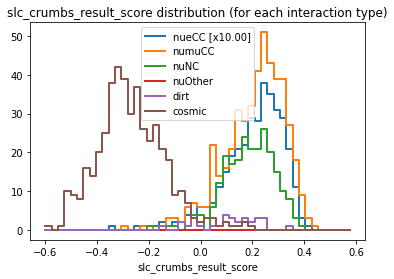

In [83]:
this_bnb = con_slcshw_bnb_nu_df
this_nue = con_slcshw_nue_nu_df

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="slc_crumbs_result_score",
             bins=np.linspace(-0.6,0.6,50),
             mult_factor=10)

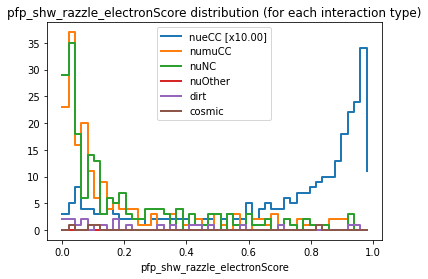

In [92]:
this_bnb = mrj_slc_bnb_nu_df
this_nue = mrj_slc_nue_nu_df

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="pfp_shw_razzle_electronScore",
             bins=np.linspace(0,1.0,50),
             mult_factor=10)

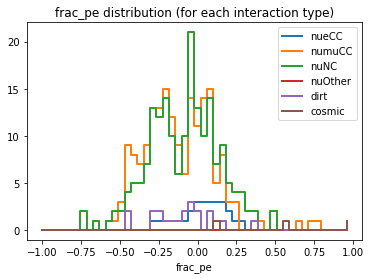

In [39]:
this_bnb = mrj_slc_bnb_nu_df
this_nue = mrj_slc_nue_nu_df
nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="frac_pe",
             bins=np.linspace(-1,1,50),
             mult_factor=None)

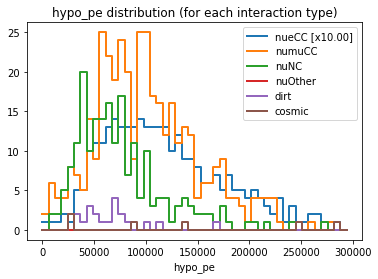

In [40]:
this_bnb = mrj_slcshw_bnb_nu_df
this_nue = mrj_slcshw_nue_nu_df

# change nan values in dataframe to -1
# this_bnb["flash_pe"] = this_bnb["flash_pe"].fillna(-1)
# this_nue["flash_pe"] = this_nue["flash_pe"].fillna(-1)

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="hypo_pe",
             bins=np.linspace(-1,3e5,50),
             mult_factor=10)

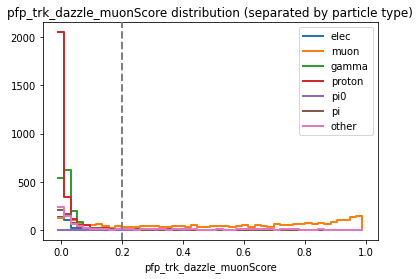

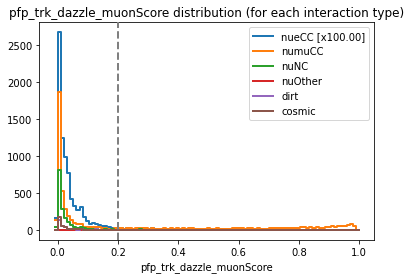

In [ ]:
this_bnb = lcr_slcpfp_bnb_nu_df
this_nue = lcr_slcpfp_nue_nu_df

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_dazzle_muonScore",
             bins=np.linspace(-0.01,1.01,50),
             cut_val = [0.2],
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_dazzle_muonScore",
             bins=np.linspace(-0.01,1.01,100),
             cut_val = [0.2],
             mult_factor=100)

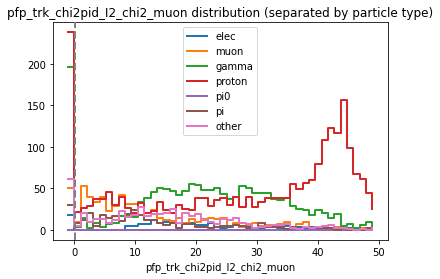

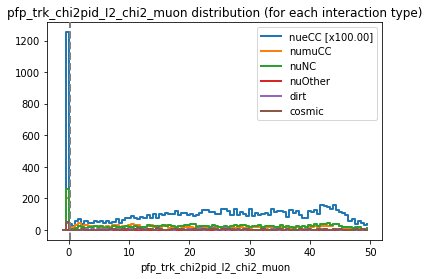

In [ ]:
this_bnb = mrj_slcpfp_bnb_nu_df
this_nue = mrj_slcpfp_nue_nu_df

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_chi2pid_I2_chi2_muon",
             bins=np.linspace(-1,50,50),
             cut_val = [0.2],
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_chi2pid_I2_chi2_muon",
             bins=np.linspace(-1,50,100),
             cut_val = [0.2],
             mult_factor=100)

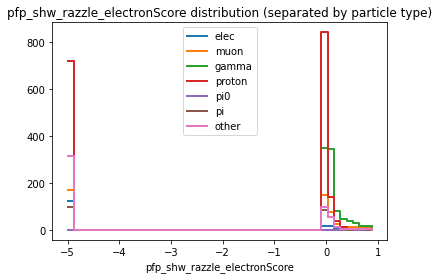

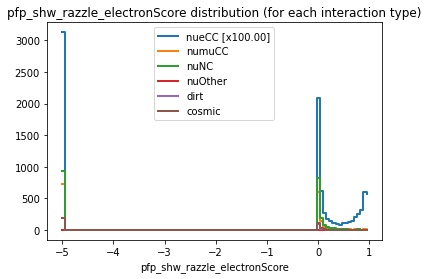

In [ ]:
this_bnb = mrj_slcpfp_bnb_nu_df[mrj_slcpfp_bnb_nu_df.pfp_trackScore < 0.6]
this_nue = mrj_slcpfp_nue_nu_df[mrj_slcpfp_nue_nu_df.pfp_trackScore < 0.6]

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_shw_razzle_electronScore",
             bins=np.linspace(-5,1.01,50),
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_shw_razzle_electronScore",
             bins=np.linspace(-5,1.01,100),
             mult_factor=100)

In [ ]:
for col in this_bnb.columns:
    if "shw" in col:
        print(col)

pfp_shw_producer
pfp_shw_start_x
pfp_shw_start_y
pfp_shw_start_z
pfp_shw_end_x
pfp_shw_end_y
pfp_shw_end_z
pfp_shw_conversion_gap
pfp_shw_bestplane
pfp_shw_bestplane_dEdx
pfp_shw_bestplane_energy
pfp_shw_razzle_electronScore
pfp_shw_truth_p_pdg
pfp_shw_truth_p_startE
pfp_shw_truth_p_endE
shw_energy
shw_plane


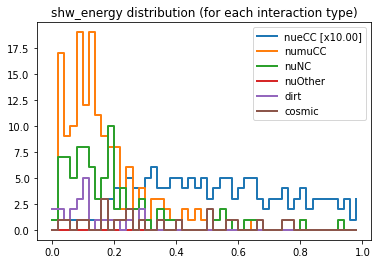

In [ ]:
this_bnb = esl_slcpfp_bnb_nu_df[esl_slcpfp_bnb_nu_df.pfp_trackScore < 0.6]
this_nue = esl_slcpfp_nue_nu_df[esl_slcpfp_nue_nu_df.pfp_trackScore < 0.6]

this_bnb = this_bnb[this_bnb.shw_energy == this_bnb.groupby(slc_idx_set).shw_energy.transform(max)]
this_nue = this_nue[this_nue.shw_energy == this_nue.groupby(slc_idx_set).shw_energy.transform(max)]

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var='shw_energy',
             label='Shower Energy [GeV]',
             bins=np.linspace(0, 1, 51),
             mult_factor=10)